# Python API for Mitsuba
The [Mitsuba](http://www.mitsuba-renderer.org/) rendering system exposes many of the C++ API calls to Python access. This notebook includes the examples from the Mitsuba documentation as well as some additional examples for composing and rendering a scene from Python. This notebook shows direct interaction via the Mitsuba Python bindings. Also available is a light wrapper around some of the Mitsuba classes to be found in the `morticia.scene.mortsuba` module. Use of this module is illustrated in other notebooks.

Documentation for the [Mitsuba Python bindings](http://www.mitsuba-renderer.org/api/group__libpython.html) is available at the Mitsuba website.

Note that this notebook runs on the assumption that there is a local installation of Mitsuba and that it is compiled in the normal RGB (SPECTRUM_SAMPLES = 3) mode. "Field" integrators are not available when Mitsuba is compiled with SPECTRUM_SAMPLES > 3. The field integrators are illustrated in this notebook, including distance, normals, UV-mapping coordinates are more. These integrators can be accessed using the Mitsuba "multichannel" integrator facility.

One potential approach is that the local copy of Mitsuba be compiled with SPECTRUM_SAMPLES = 3 for the use of field integrators and that additional compute platforms be available with Mitsuba compiled having SPECTRUM_SAMPLES > 3. The most consistent approach is to compile all instances of Mitsuba with SPECTRUM_SAMPLES = 3 and run Mitsuba multiple times to render any scenes requiring more than 3 spectral channels.

In [10]:
import os, sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
# Note that the MORTICIA scene module for Mitsuba is imported as mormit,
# whereas the Mitsuba Python API is imported as mitsuba
import morticia.rad.radute as radute
import morticia.scene.mortsuba as mormit
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
mpl.rc('font', **font)
# Use the following magic to configure the backend for 
# PDF graphic generation if exporting for publication
backend_figure_format = 'png'
if backend_figure_format:
    %config InlineBackend.figure_format = '$backend_figure_format'
# Now import the mitsuba Python extension
# The following applies only to Windows
# NOTE: remember to specify paths using FORWARD slashes (i.e. '/' instead of
# '\' to avoid pitfalls with string escaping)
# Configure the search path for the Python extension module
my_path_to_mitsuba = 'C:/Users/DGriffith/Downloads/Mitsuba/Mitsuba 0.5.0'
sys.path.append(my_path_to_mitsuba + '/python/2.7')
# Ensure that Python will be able to find the Mitsuba core libraries
os.environ['PATH'] = my_path_to_mitsuba + os.pathsep + os.environ['PATH']
# On other platforms, measures may also be required to ensure that Python can find the Mitsuba package
import mitsuba
# Use auto reload of librad for development purposes
%load_ext autoreload
%autoreload 1
%aimport morticia.scene.mortsuba
%aimport 
%matplotlib inline
casetitle = 'Mitsuba Python API' 
subtitle = 'Examples and Exercises'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
morticia.scene.mitsuba morticia.scene.mortsuba

Modules to skip:



## Accessing Core Funcions

In [4]:
# A simple 3-vector transformation operation
from mitsuba.core import *
# Create a normalized direction vector
myVector = normalize(mitsuba.core.Vector(1.0, 2.0, 3.0))
# 90 deg. rotation around the Y axis
trafo = Transform.rotate(mitsuba.core.Vector(0, 1, 0), 90)
# Apply the rotation and display the result
print(trafo * myVector)

[0.801784, 0.534522, -0.267261]


## Loading a Scene
Scenes are loaded using the file resolver to find the .xml scene file and then the [SceneHandler](http://www.mitsuba-renderer.org/api/classmitsuba_1_1_scene_handler.html) to load the scene.

Here, the scene cubi.xml contains a CUBI object used in thermal signatorics. The CUBI is also used as a standard object for field validation.

In [5]:
from mitsuba.render import SceneHandler
# Get a reference to the thread's file resolver
fileResolver = Thread.getThread().getFileResolver()
# Register any searchs path needed to load scene resources (optional)
fileResolver.appendPath('./MitsubaScenes/')
# Optional: supply parameters that can be accessed
# by the scene (e.g. as $myParameter)
paramMap = StringMap()
paramMap['myParameter'] = 'value'

In [6]:
# Load the scene from an XML file
scene = SceneHandler.loadScene(fileResolver.resolve("./MitsubaScenes/cubi.xml"), paramMap)
scene.setDestinationFile('./MitsubaScenes/cubiEXR')  # Set the name of the render output file
# Display a textual summary of the scene's contents
print(scene)

Scene[
  sensor = ref<PerspectiveCameraImpl>[ref=2, ptr=PerspectiveCamera[
    xfov = 40,
    nearClip = 0.01,
    farClip = 10000,
    worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
      -0.707107, -0.235706, -0.666665, 2.12711;
      -0.707107, 0.235706, 0.666665, -2.12711;
      0, 0.942807, -0.333339, 1.06356;
      0, 0, 0, 1
    ]],
    sampler = IndependentSampler[
      sampleCount = 1
    ],
    film = HDRFilm[
      size = [1024, 768],
      fileFormat = 1,
      pixelFormat = rgb, luminance, rgb, 
      channelNames = "normal.R", "normal.G", "normal.B", "distance.Y", "uv.R", "uv.G", "uv.B", 
      componentFormat = float32,
      cropOffset = [0, 0],
      cropSize = [1024, 768],
      banner = 1,
      filter = GaussianFilter[stddev=0.500000, radius=2.000000]
    ],
    medium = ref<Medium>[null],
    shutterOpen = 0,
    shutterOpenTime = 0
  ]],
  sampler = ref<IndependentSampler>[ref=2, ptr=IndependentSampler[
    sampleCount = 1
  ]],
  integrator = ref<

## Rendering a Scene
First the scheduler and workers are set up and then the render job is submitted to a job queue. The queue should be set up only once per host. Either execute the next cell for execution on the local host, or the following cell for remote execution.

In [7]:
# Run this cell only once per session
from mitsuba.render import RenderQueue, RenderJob
import multiprocessing
scheduler = Scheduler.getInstance()

# Start up the scheduling system with one worker per local core
for i in range(0, multiprocessing.cpu_count()):
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
scheduler.start()

The next cell shows how to render via a remote instance of *mtssrv*. Thas can be tested on the local host by specifying the -i 127.0.0.1 option with *mtssrv*.

In [5]:
# Alternatively set up remote workers
# Run this cell only once per session

# Connect to a socket on a named host or IP address
# 7554 is the default port of 'mtssrv'
# The IP number 127.0.0.1 usually refers to the local host, but run mtssrv -i 127.0.0.1
stream = SocketStream('146.64.248.22', 7554)

In [6]:
# Create a remote worker instance that communicates over the stream
remoteWorker = RemoteWorker('netWorker', stream)
scheduler = Scheduler.getInstance()
# Register the remote worker (and any other potential workers)
scheduler.registerWorker(remoteWorker)
scheduler.start()

In [8]:
from mitsuba.render import RenderQueue, RenderJob
# Create a queue for tracking render jobs
queue = RenderQueue()

In [9]:
# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()
# Print some statistics about the rendering process
print(Statistics.getInstance().getStats())

------------------------------------------------------------
 * Loaded plugins :
    -  plugins\diffuse.dll [Smooth diffuse BRDF]
    -  plugins\envmap.dll [Environment map]
    -  plugins\field.dll [Field extraction integrator]
    -  plugins\gaussian.dll [Gaussian reconstruction filter]
    -  plugins\hdrfilm.dll [High dynamic range film]
    -  plugins\independent.dll [Independent sampler]
    -  plugins\lanczos.dll [Lanczos Sinc filter]
    -  plugins\multichannel.dll [Multi-channel integrator]
    -  plugins\perspective.dll [Perspective camera]
    -  plugins\rectangle.dll [Rectangle intersection primitive]
    -  plugins\sky.dll [Skylight emitter]
    -  plugins\sphere.dll [Sphere intersection primitive]
    -  plugins\sunsky.dll [Sun & sky emitter]

  * General :
    -  Normal rays traced : 786.432 K

  * Texture system :
    -  Cumulative MIP map memory allocations : 1 MiB
------------------------------------------------------------


In [8]:
# Read the data resulting from the Mitsuba run
channel_names, im_dict, header = radute.readOpenEXR('./MitsubaScenes/cubiEXR.exr')
# Print keys of what came back in the image dictionary
print im_dict.keys()

['normal', 'normal.G', 'uv.R', 'uv', 'distance.Y', 'normal.B', 'uv.B', 'uv.G', 'normal.R']


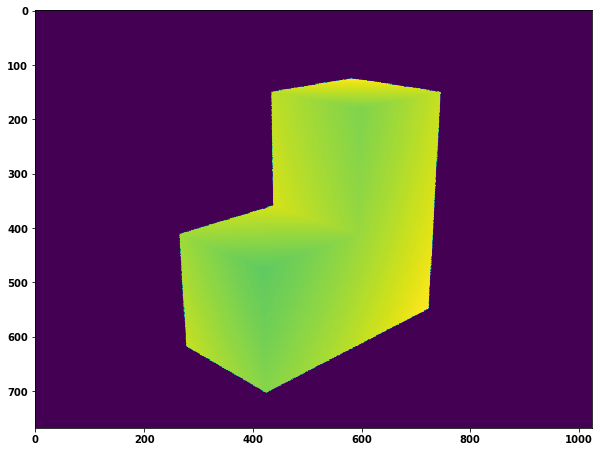

In [11]:
# Plot the distance data
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['distance.Y'])

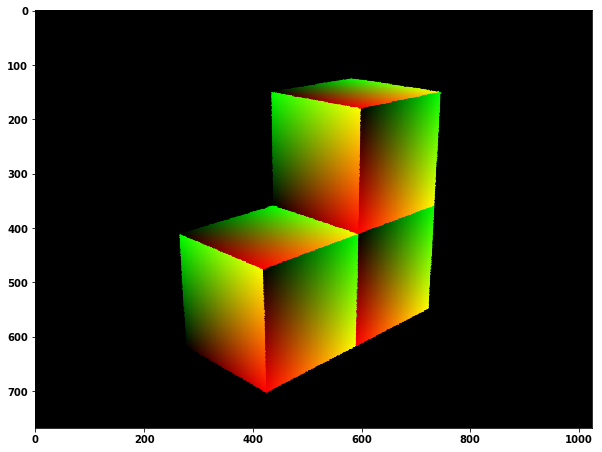

In [12]:
# Plot the UV data (u, v coordinates on each pixel hit)
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['uv'])

In [13]:
# Plot the UV data (u, v coordinates on each pixel hit)
plt.figure(figsize=(10.24, 7.68))
plt.imshow(im_dict['normal'])

ValueError: Floating point image RGB values must be in the 0..1 range.

In [14]:
# Load the scene from an XML file for the low dynamic range version
# Supply parameters that can be accessed
# by the scene (e.g. as $myParameter)
paramMap = StringMap()
paramMap['surfaceAlbedo'] = '0.5 0.5 0.5'
paramMap['CUBIfaceReflectance'] = '1.0 1.0 1.0'
scenePNG = SceneHandler.loadScene(fileResolver.resolve("./MitsubaScenes/cubiPNG.xml"), paramMap)
scenePNG.setDestinationFile('./MitsubaScenes/cubiPNG')  # Set the name of the render output file
# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', scenePNG, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()

# Take a look at the CUBI
cubi_img = mpimg.imread('./MitsubaScenes/cubiPNG.png')
plt.figure(figsize=(10.24, 7.68))
plt.imshow(cubi_img)

NameError: name 'queue' is not defined

In [15]:
# Load the material preview scene from an XML file
mat_scene = SceneHandler.loadScene(fileResolver.resolve("./MitsubaScenes/matpreview.xml"))
mat_scene.setDestinationFile('./MitsubaScenes/mat_ball')  # Set the name of the render output file
# Display a textual summary of the scene's contents
print(mat_scene)

Scene[
  sensor = ref<PerspectiveCameraImpl>[ref=2, ptr=PerspectiveCamera[
    xfov = 37.8664,
    nearClip = 0.01,
    farClip = 10000,
    worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
      -0.685884, -0.317366, -0.654861, 3.69558;
      -0.727631, 0.312466, 0.610671, -3.46243;
      0.0108156, 0.895346, -0.44524, 3.25463;
      0, 0, 0, 1
    ]],
    sampler = LowDiscrepancySampler[
      sampleCount = 64,
      dimension = 4
    ],
    film = LDRFilm[
      size = [683, 512],
      fileFormat = 0,
      pixelFormat = rgb,
      gamma = -1,
      cropOffset = [0, 0],
      cropSize = [683, 512],
      banner = 0,
      method = gamma,
      exposure = 0,
      reinhardKey = 0.18,
      reinhardBurn = 0,
      filter = GaussianFilter[stddev=0.500000, radius=2.000000]
    ],
    medium = ref<Medium>[null],
    shutterOpen = 0,
    shutterOpenTime = 0
  ]],
  sampler = ref<LowDiscrepancySampler>[ref=2, ptr=LowDiscrepancySampler[
    sampleCount = 64,
    dimension = 4


In [16]:
# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', mat_scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()


In [ ]:
# Perform the animation run
mat_sensor = mat_scene.getSensor()
mat_sensor.setShutterOpen(0)
mat_sensor.setShutterOpenTime(1)
stepSize = 5
for i in range(0,360 / stepSize):
    rotationCur = Transform.rotate(Vector(0, 0, 1), i*stepSize)
    rotationNext = Transform.rotate(Vector(0, 0, 1), (i+1)*stepSize)
    trafoCur = Transform.lookAt(rotationCur * Point(0,-6,4),
        Point(0, 0, .5), rotationCur * Vector(0, 1, 0))
    trafoNext = Transform.lookAt(rotationNext * Point(0,-6,4),
        Point(0, 0, .5), rotationNext * Vector(0, 1, 0))
    atrafo = AnimatedTransform()
    atrafo.appendTransform(0, trafoCur)
    atrafo.appendTransform(1, trafoNext)
    atrafo.sortAndSimplify()
    mat_sensor.setWorldTransform(atrafo)
    mat_scene.setDestinationFile('./MitsubaScenes/frame_%03i' % i)
    job = RenderJob('job_%i' % i, mat_scene, queue)
    job.start()
    queue.waitLeft(0)

In [ ]:
# Release resources
queue.join()


# Creating a Scene
The first example from the Mitsuba manual on scene construction shows how to build a sensor with a film.

First a generic plugin manager is created and then a plugin instance of specific type is assigned, in this case a perspective camera with HD film.

In [17]:
from mitsuba.render import Scene
pmgr = PluginManager.getInstance()  # Get generic plugin manager instance
# Encodes parameters on how to instantiate the 'perspective' plugin
sensorProps = Properties('perspective')
sensorProps['toWorld'] = Transform.lookAt(
    Point(0, 0, -10), # Camera origin
    Point(0, 0, 0), # Camera target
    Vector(0, 1, 0) # 'up' vector
    )
sensorProps['fov'] = 45.0
# Encodes parameters on how to instantiate the 'ldrfilm' plugin
filmProps = Properties('ldrfilm')
filmProps['width'] = 1920
filmProps['height'] = 1080
# Load and instantiate the plugins
sensor = pmgr.createObject(sensorProps)
film = pmgr.createObject(filmProps)
# First configure the film and then add it to the sensor
film.configure()
sensor.addChild('film', film)
# Now, the sensor can be configured
sensor.configure()
# Print the sensor
sensor

PerspectiveCamera[
  xfov = 45,
  nearClip = 0.01,
  farClip = 10000,
  worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
    1, 0, 0, 0;
    0, 1, 0, 0;
    0, 0, 1, -10;
    0, 0, 0, 1
  ]],
  sampler = IndependentSampler[
    sampleCount = 4
  ],
  film = LDRFilm[
    size = [1920, 1080],
    fileFormat = 0,
    pixelFormat = rgb,
    gamma = -1,
    cropOffset = [0, 0],
    cropSize = [1920, 1080],
    banner = 1,
    method = gamma,
    exposure = 0,
    reinhardKey = 0.18,
    reinhardBurn = 0,
    filter = GaussianFilter[stddev=0.500000, radius=2.000000]
  ],
  medium = ref<Medium>[null],
  shutterOpen = 0,
  shutterOpenTime = 0
]

## Creating a Scene using Dictionaries
The following cell shows how to do the same sensor/film creation using dictionaries instead. This sensor/film has the same properties as that created in the previous cell.

In [18]:
pmgr = PluginManager.getInstance()
sensor = pmgr.create({
    'type' : 'perspective',
    'toWorld' : Transform.lookAt(
        Point(0, 0, -10),
        Point(0, 0, 0),
        Vector(0, 1, 0)
    ),
    'film' : {
        'type' : 'ldrfilm',
        'width' : 1920,
        'height' : 1080
    }
})
# Now, the sensor can be configured
sensor.configure()

In [19]:
# Print out the sensor plugin instance
# Note how there are considerably more properties that has been given default values
sensor

PerspectiveCamera[
  xfov = 41.323,
  nearClip = 0.01,
  farClip = 10000,
  worldTransform = ref<AnimatedTransform>[ref=1, ptr=Matrix4x4[
    1, 0, 0, 0;
    0, 1, 0, 0;
    0, 0, 1, -10;
    0, 0, 0, 1
  ]],
  sampler = IndependentSampler[
    sampleCount = 4
  ],
  film = LDRFilm[
    size = [1920, 1080],
    fileFormat = 0,
    pixelFormat = rgb,
    gamma = -1,
    cropOffset = [0, 0],
    cropSize = [1920, 1080],
    banner = 1,
    method = gamma,
    exposure = 0,
    reinhardKey = 0.18,
    reinhardBurn = 0,
    filter = GaussianFilter[stddev=0.500000, radius=2.000000]
  ],
  medium = ref<Medium>[null],
  shutterOpen = 0,
  shutterOpenTime = 0
]

## Full Scene Creation
The previous examples only provided snippets of a scene. The following is a full scene creation example from the Mitsuba manual.

In [20]:
full_scene = Scene()
# Create a sensor, film & sample generator
full_scene.addChild(pmgr.create({
    'type' : 'perspective',
    'toWorld' : Transform.lookAt(
        Point(0, 0, -10),
        Point(0, 0, 0),
        Vector(0, 1, 0)
    ),
    'film' : {
        'type' : 'ldrfilm',
                'width' : 1920,
                'height' : 1080
    },
    'sampler' : {
        'type' : 'ldsampler',
        'sampleCount' : 2
    }
}))
# Set the integrator
full_scene.addChild(pmgr.create({
    'type' : 'path'
}))
# Add a light source
full_scene.addChild(pmgr.create({
    'type' : 'point',
    'position' : Point(5, 0, -10),
    'intensity' : Spectrum(100)
}))
# Add a shape
full_scene.addChild(pmgr.create({
    'type' : 'sphere',
    'center' : Point(0, 0, 0),
    'radius' : 1.0,
    'bsdf' : {
        'type' : 'diffuse',
        'reflectance' : Spectrum(0.4)
    }
}))
full_scene.setDestinationFile('ball')  # Set the name of the render output file
# By default, the output file will be a .png
full_scene.configure()

In [21]:
# Render the full scene just created using the existing job queus
job = RenderJob('myRenderJob', full_scene, queue)
job.start()
# Wait for all jobs to finish and release resources
queue.waitLeft(0)
queue.join()
# Print some statistics about the rendering process
print(Statistics.getInstance().getStats())

------------------------------------------------------------
 * Loaded plugins :
    -  plugins\checkerboard.dll [Checkerboard texture]
    -  plugins\diffuse.dll [Smooth diffuse BRDF]
    -  plugins\envmap.dll [Environment map]
    -  plugins\field.dll [Field extraction integrator]
    -  plugins\gaussian.dll [Gaussian reconstruction filter]
    -  plugins\halton.dll [Halton QMC sampler]
    -  plugins\hdrfilm.dll [High dynamic range film]
    -  plugins\independent.dll [Independent sampler]
    -  plugins\lanczos.dll [Lanczos Sinc filter]
    -  plugins\ldrfilm.dll [Low dynamic range film]
    -  plugins\ldsampler.dll [Low discrepancy sampler]
    -  plugins\multichannel.dll [Multi-channel integrator]
    -  plugins\path.dll [MI path tracer]
    -  plugins\perspective.dll [Perspective camera]
    -  plugins\plastic.dll [Smooth plastic BRDF]
    -  plugins\point.dll [Point emitter]
    -  plugins\rectangle.dll [Rectangle intersection primitive]
    -  plugins\serialized.dll [Serialize

In [22]:
# Show the result
ball_img = mpimg.imread('ball.png')
plt.figure(figsize=(10, 5.625))
plt.imshow(ball_img)

In [25]:
import datetime
now = datetime.datetime.now()
print 'Completed Run at ', str(now)
# After executing this cell, save the notebook before running the 
# publish cells below
# To run the complete notebook, select this cell
# and then choose Cell->Run All Above from the menu

Completed Run at  2017-03-22 14:13:16.257000


In [24]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [27]:
result_folder = './MitsubaScenes'
publish = True
# Run this cell to publish, but save the notebook beforehand
# The contents of this cell strictly for publishing the notebook.
if publish:
    notebook_name = theNotebook + '.ipynb'
    # Run nbconvert to create a tex file as well as pdf graphic files
    !jupyter nbconvert --to latex $notebook_name
    # Do touchups    
    def touchup_build_tex(tex_file, touchups):
        # Read the LaTeX file
        f = open(tex_file,'r')
        filedata = f.read()
        f.close()
        # Perform touchups
        for src, target in touchups.iteritems():
                filedata = filedata.replace(src, target)
        # Write file again
        f = open(tex_file,'w')
        f.write(filedata)
        f.close()
        # Build PDF using LaTeX
        !pdflatex $tex_file > pdflatex.out
        
    touchups = {'[11pt]{article}': '[11pt, a4paper, landscape]{scrartcl}',
                'title{' + theNotebook + '}': 
                'title{' + casetitle + '}' + 
                '\subtitle{' + subtitle + '}'}
    touchup_build_tex(theNotebook + '.tex', touchups)
    # Move the compiled pdf to the results folder
    import os
    publication = result_folder + os.sep + casename + '.pdf'
    if os.path.exists(publication):
        os.remove(publication)
    os.rename(theNotebook + '.pdf', publication)

[NbConvertApp] Converting notebook 01a-Mitsuba-Introduction.ipynb to latex
[NbConvertApp] Support files will be in 01a-Mitsuba-Introduction_files\
[NbConvertApp] Making directory 01a-Mitsuba-Introduction_files
[NbConvertApp] Making directory 01a-Mitsuba-Introduction_files
[NbConvertApp] Making directory 01a-Mitsuba-Introduction_files
[NbConvertApp] Making directory 01a-Mitsuba-Introduction_files
[NbConvertApp] Making directory 01a-Mitsuba-Introduction_files
[NbConvertApp] Writing 77133 bytes to 01a-Mitsuba-Introduction.tex


NameError: name 'casename' is not defined